# Reupload classifier using a single qbit



In [46]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, QuantumCircuit
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit import Parameter, ParameterVector
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN, OpflowQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit.opflow import PauliSumOp, StateFn, OperatorBase, ExpectationBase

from typing import Union

from qiskit_machine_learning.exceptions import QiskitMachineLearningError

from IPython.display import clear_output

from dataset import read_dataset, divide_dataset, balance_dataset

algorithm_globals.random_seed = 42

quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1024)

# Data

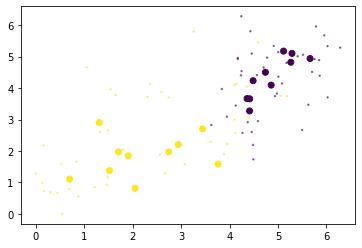

In [69]:
# read the data
dataset = read_dataset()

# extract a balances subset containing a limited number of points
npts = 100
dataset = balance_dataset(dataset, npts)

# only consider a subset of the features
features = [0,1,2]
nfeatures = len(features)
dataset.features = dataset.features[:,features]

# normalize the data between 0 and 2pi
dataset.features -= dataset.features.min(0)
dataset.features /= dataset.features.max(0)
dataset.features *= 2*np.pi

# divide the dataset in train/test
train_dataset, test_dataset = divide_dataset(dataset, shuffle=False)

# plot the data
plt.scatter(train_dataset.features[:,0],train_dataset.features[:,1],c=train_dataset.labels,alpha=0.5,s=2)
plt.scatter(test_dataset.features[:,0],test_dataset.features[:,1],c=test_dataset.labels)

# Classification with single qubit classifier and data reuploading

Data Reuploading has been defined in that paper : https://arxiv.org/pdf/1907.02085.pdf 
and a nice tutorial can found at pannylane https://pennylane.ai/qml/demos/tutorial_data_reuploading_classifier.html

The main idea is to encode classical data in SU2 rotations and add a learnable layer to it. The "network" is then constructed from repeating sequence of data-encoding and learnable layers. The classification is made by measuring the state of the qubit after the series of transormation

Let's first create a general rotation blocs for the input and the parameters:

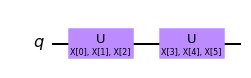

In [70]:
class Encode(QuantumCircuit):
    
    def __init__(self, num_feat, nqbit=1):
        super().__init__(nqbit)
        
        nbloc = -(num_feat//-3)
        
        self.params = ParameterVector(name='X', length=num_feat)
        idx = 0
        for i in range(nbloc):
            self.u(self.params[idx+0],self.params[idx+1],self.params[idx+2], 0)
            idx += 3
            
encode = Encode(6)
encode.draw(output='mpl')

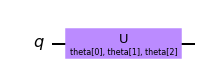

In [81]:
class TrainLayer(QuantumCircuit):
    
    def __init__(self, nqbit=1, params = None, param_name='theta'):
        super().__init__(nqbit)
        if params is None:
            self.params = ParameterVector(name=param_name, length=3)
            self.u(self.params[0],self.params[1],self.params[2], 0)
        else:
            self.u(params[0],params[1],params[2], 0)
        
layer = TrainLayer()
layer.draw(output='mpl')

W, ['W[0]', 'W[1]', 'W[2]', 'W[3]', 'W[4]', 'W[5]']
0 3
3 6


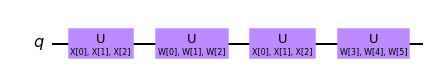

In [86]:
class ReuploadQNN(OpflowQNN):
    
    def __init__(self, num_features=3, reps=2):
        
        num_qubits=1
    

        self._encode = Encode(num_features)
        layer = TrainLayer
            
        input_params = list(self._encode.params)
            
        self._transform = []
        weight_params = ParameterVector(name='W', length=reps*3)
        self.reps = reps
        
        self._circuit = QuantumCircuit(num_qubits)
        
        for i in range(reps):
            idx0, idx1 = i*3,(i+1)*3
            self._transform.append(layer(params = weight_params[idx0:idx1]))
            self._circuit.append(self._encode, [0])
            self._circuit.append(self._transform[i],[0])
        
        
        self.observable = PauliSumOp.from_list([("Z" * num_qubits, 1)])

        
        # combine all to operator
        operator = ~StateFn(self.observable) @ StateFn(self._circuit)

        super().__init__(
            operator=operator,
            input_params=input_params,
            weight_params=weight_params,
            exp_val=None,
            quantum_instance=None,
            input_gradients=False
        )

    @property
    def encode(self) -> QuantumCircuit:
        """Returns the used feature map."""
        return self._encode

    @property
    def transform(self) -> [QuantumCircuit]:
        """Returns the used ansatz."""
        return self._transform

    @property
    def circuit(self) -> QuantumCircuit:
        """Returns the underlying quantum circuit."""
        return self._circuit

    @property
    def num_qubits(self) -> int:
        """Returns the number of qubits used by ansatz and feature map."""
        return self._circuit.num_qubits
    
    @property
    def num_features(self) -> int:
        """Returns the number of features"""
        return self._encode.params.num_features
        
        
reup_qnn = ReuploadQNN()
reup_qnn._circuit.decompose().draw(output="mpl")

In [102]:
# We can do a forward pass using any of the datapoints.
# the output of the QNN  lies in [-1, +1]
reup_qnn.forward(train_dataset.features[4, :], algorithm_globals.random.random((reup_qnn.num_weights)))

array([[0.92863951]])

We will add a callback function called callback_graph. This will be called for each iteration of the optimizer and will be passed two parameters: the current weights and the value of the objective function at those weights. For our function, we append the value of the objective function to an array so we can plot iteration versus objective function value and update the graph with each iteration. However, you can do whatever you want with a callback function as long as it gets the two parameters mentioned passed.

In [91]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

# Classification

we can now create the classfier and use it on our data.

In [92]:
# construct neural network classifier
opflow_classifier = NeuralNetworkClassifier(reup_qnn, optimizer=COBYLA(), callback=callback_graph)

In [98]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
opflow_classifier.fit(train_dataset.features, train_dataset.labels)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# reset data labels
test_dataset.labels[test_dataset.labels==0] = -1

# score classifier
opflow_classifier.score(test_dataset.features, test_dataset.labels)

TypeError: fit() got an unexpected keyword argument 'n'

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


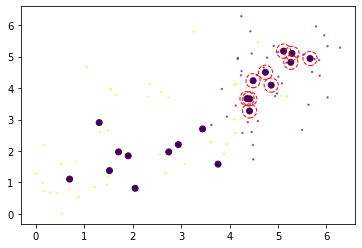

In [97]:
# plot the data
predicted_labels = opflow_classifier.predict(test_dataset.features)

plt.scatter(train_dataset.features[:,0],train_dataset.features[:,1],c=train_dataset.labels,alpha=0.5,s=2)
plt.scatter(test_dataset.features[:,0],test_dataset.features[:,1],c=predicted_labels)
for x, y, yp in zip(test_dataset.features, test_dataset.labels, predicted_labels):
    if y != yp:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linestyle='--',linewidths=1)
        